In [1]:
import run_test as tests

In [2]:
p_results = [f"simple.txttest.txtresult_{i}.txt" for i in range(11)]
p_results

['simple.txttest.txtresult_0.txt',
 'simple.txttest.txtresult_1.txt',
 'simple.txttest.txtresult_2.txt',
 'simple.txttest.txtresult_3.txt',
 'simple.txttest.txtresult_4.txt',
 'simple.txttest.txtresult_5.txt',
 'simple.txttest.txtresult_6.txt',
 'simple.txttest.txtresult_7.txt',
 'simple.txttest.txtresult_8.txt',
 'simple.txttest.txtresult_9.txt',
 'simple.txttest.txtresult_10.txt']

In [3]:
p_source = "simple.txttest.txt"

In [4]:
from em import GaussianModel, WeibullModel, EM
import numpy as np
from itertools import combinations
from scipy.stats import norm, weibull_min
import sys
import time
import types
import ast
from statistics import mean, median

In [5]:
def Describe(p_source, p_results):
    data = {}
    with open(p_source, "r") as f:
        for l in f:
            splitted = l.split(";")
            ind, distr_count = (int(i) for i in splitted[:2])
            O = []
            for i in range(distr_count):
                O.append(tuple((float(t) for t in splitted[2 + i * 2 : 4 + i * 2])))

            start_O = []
            for i in range(distr_count):
                r = 2 + distr_count * 2 + i * 2
                start_O.append(tuple((float(t) for t in splitted[r : r + 2])))

            x = [float(t) for t in splitted[4 + distr_count * 2 :]]

            data[ind] = types.SimpleNamespace()
            data[ind].ind = i
            data[ind].k = distr_count
            data[ind].O = start_O
            data[ind].x = x
    for p_result in p_results:
        with open(p_result, "r") as f:
            for l in f:
                splitted = l.split("\t")
                ind = int(splitted[0])
                ind2 = int(splitted[1])
                res = ast.literal_eval(
                    splitted[4].replace("nan", "None").replace("inf", "None")[:-1]
                )
                data[ind].found_O = res[0]
                data[ind].found_w = res[1]
                data[ind].steps = res[2] + 1
                data[ind].time = res[3]
    return data

In [6]:
results = Describe(p_source, p_results)
for res in results.values():
    res.size = len(res.x) // res.k // 10 * 10

In [7]:
count_failed = 0
results_failed = list()
results_success = list()
for res in results.values():
    if (
        (res.steps >= 75)
        or (None in res.found_w)
        or (True in [None in x for x in res.found_O])
    ):
        count_failed += 1
        results_failed.append(res)
    else:
        results_success.append(res)
count_failed

66

In [8]:
results_success_k = {}
for res in results_success:
    if not res.k in results_success_k:
        results_success_k[res.k] = []
    results_success_k[res.k].append(res)

In [9]:
for k in results_success_k.keys():
    print(f"k = {k}, successes = {len(results_success_k[k])}")

k = 1, successes = 80
k = 2, successes = 71
k = 3, successes = 67
k = 4, successes = 67
k = 5, successes = 49


In [10]:
results_success_k_size = dict()
for k in results_success_k.keys():
    if k not in results_success_k_size:
        results_success_k_size[k] = dict()
    for res in results_success_k[k]:
        if res.size not in results_success_k_size[k]:
            results_success_k_size[k][res.size] = []
        results_success_k_size[k][res.size].append(res)

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

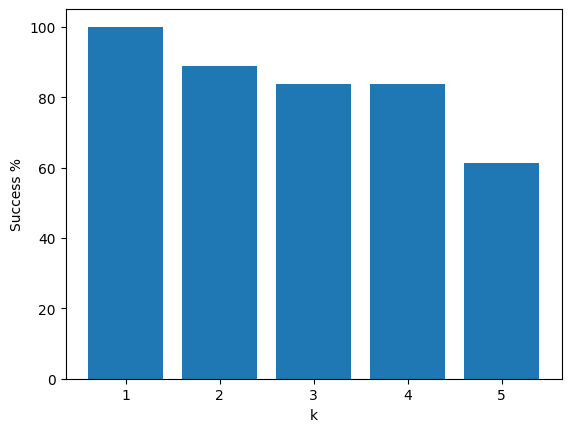

In [12]:
x = [1, 2, 3, 4, 5]
y = []

for k in x:
    y.append(len(results_success_k[k]) / 80 * 100)

plt.bar(x, y)
plt.xlabel("k")
plt.ylabel("Success %")
plt.show()

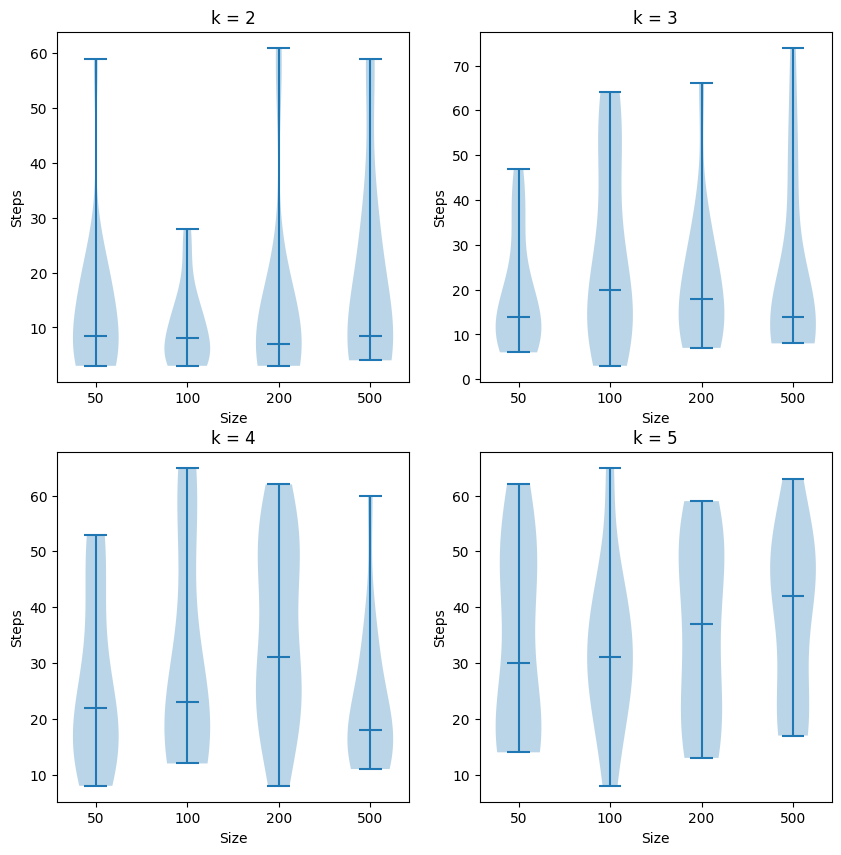

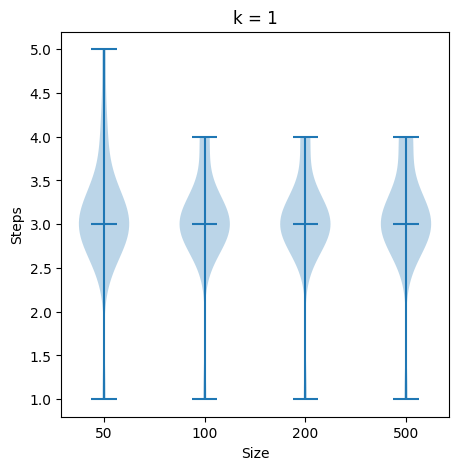

In [13]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, k in enumerate([1, 2, 3, 4, 5]):
    ind = ((i - 1) // 2, (i - 1) % 2)
    x = []
    all_data = []
    for size in results_success_k_size[k].keys():
        x.append(size)
        all_data.append([res.steps for res in results_success_k_size[k][size]])

    if k > 1:
        ax = axs[ind]
    else:
        _, ax = plt.subplots(figsize=(5, 5))
    ax.violinplot(all_data, showmeans=False, showmedians=True)
    ax.set_xticks([y + 1 for y in range(len(all_data))], labels=x)
    ax.set_xlabel("Size")
    ax.set_ylabel("Steps")
    ax.set_title(f"k = {k}")

Text(0, 0.5, 'Steps median')

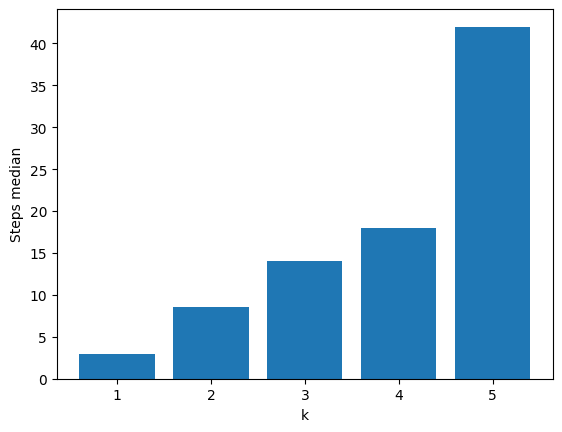

In [14]:
x = [1, 2, 3, 4, 5]
for size in [50, 100, 200, 500]:
    steps = []
    for k in x:
        steps.append([res.steps for res in results_success_k_size[k][size]])
        steps[-1] = median(steps[-1])

plt.bar(x, steps)
plt.xlabel("k")
plt.ylabel("Steps median")

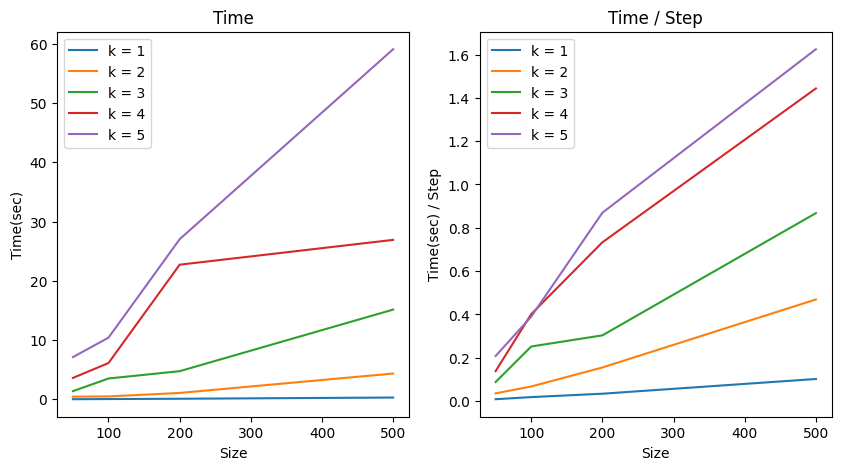

In [45]:
from scipy.interpolate import make_interp_spline

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

for i, k in enumerate([1, 2, 3, 4, 5]):
    x = []
    all_data = []
    for size in results_success_k_size[k].keys():
        x.append(size)
        all_data.append(median([res.time for res in results_success_k_size[k][size]]))

    ax[0].plot(x, all_data, label=f"k = {k}")

for i, k in enumerate([1, 2, 3, 4, 5]):
    x = []
    all_data = []
    for size in results_success_k_size[k].keys():
        x.append(size)
        all_data.append(
            median([res.time / res.steps for res in results_success_k_size[k][size]])
        )

    ax[1].plot(x, all_data, label=f"k = {k}")


ax[0].set_xlabel("Size")
ax[0].set_ylabel("Time(sec)")
ax[0].set_title("Time")
ax[0].legend()

ax[1].set_xlabel("Size")
ax[1].set_ylabel("Time(sec) / Step")
ax[1].set_title("Time / Step")
ax[1].legend()
plt.show()

In [76]:
def occur(X, O, w):
    return np.sum([np.log(np.sum([w * weibull_min.pdf(X, O[j][0], scale=O[j][1]) for j, w in enumerate(w)])) for x in X]) / len(X)

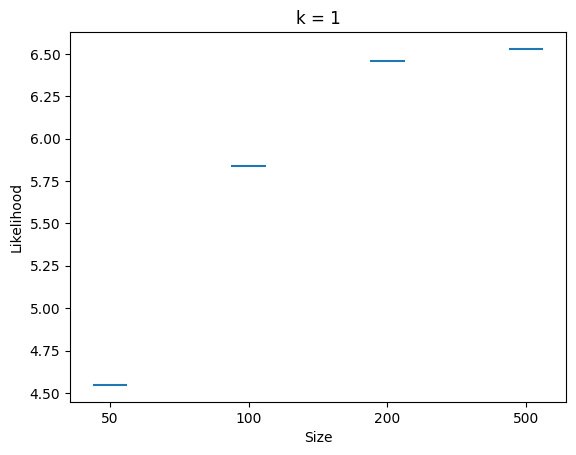

KeyboardInterrupt: 

In [79]:
for k in [1, 2, 3, 4, 5]:
    x = []
    all_data = []
    for size in results_success_k_size[k].keys():
        x.append(size)
        all_data.append(
            [
                occur(res.x, res.found_O, res.found_w)
                for res in results_success_k_size[k][size]
            ]
        )
    plt.violinplot(all_data, showmeans=True)
    plt.xticks([y + 1 for y in range(len(all_data))], labels=x)
    plt.xlabel("Size")
    plt.ylabel("Likelihood")
    plt.title(f"k = {k}")
    plt.show()

In [80]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10, 10))

for i, k in enumerate([1, 2, 3, 4, 5]):
    ind = ((i - 1) // 2, (i - 1) % 2)
    x = []
    all_data = []
    for size in results_success_k_size[k].keys():
        x.append(size)
        all_data.append(
            [
                occur(res.x, res.found_O, res.found_w)
                for res in results_success_k_size[k][size]
            ]
        )

    if k > 1:
        ax = axs[ind]
    else:
        _, ax = plt.subplots(figsize=(5, 5))
    ax.violinplot(all_data, showmeans=True, showmedians=False)
    ax.set_xticks([y + 1 for y in range(len(all_data))], labels=x)
    ax.set_xlabel("Size")
    ax.set_ylabel("NLL")
    ax.set_title(f"k = {k}")